In [179]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
import sys 
sys.path.append("../")
from sklearn.metrics import balanced_accuracy_score
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sn
import numpy as np
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import cross_val_score
import umap
import sklearn
import pandas as pd 
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from core.utils import (find_non_numerical_columns,categorize_columns,evaluate_cross_validation,
                   convert_df_to_numeric_df,scale_columns,evaluate_model,optimize_xgb)

from core.mlp_utils import (get_optimizer,train_loop,val_loss,
                   train_model,MatrixDataset)
                   
from core.mlp import MLPModel


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
df = pd.read_csv("../data/assignement_with_bert_sentiments")
target = df["Exited"]
numerical_df = convert_df_to_numeric_df(df,["RowNumber", "CustomerId", "Surname","CustomerFeedback","Exited"])
numerical_df["RatioSalary"] = numerical_df["EstimatedSalary"] /  (numerical_df["Balance (EUR)"]+1)
numerical_df["RatioProducst"] = numerical_df["NumberOfProducts"] / (numerical_df["Tenure"] +1)
numerical_df["RatioCards"] = numerical_df["HasCreditCard"] &  numerical_df["IsActiveMember"]
numerical_df["ProductSalary"] = numerical_df["Balance (EUR)"] *  numerical_df["CreditScore"]

scaled_df = scale_columns(numerical_df,columns=["EstimatedSalary","Balance (EUR)","CreditScore","Age","Tenure","RatioSalary",
                                    "RatioProducst","RatioCards","ProductSalary"])

In [181]:
scaled_df = scaled_df.reset_index(drop=True).drop(columns=["Unnamed: 0"])

In [182]:
df_encoded = pd.get_dummies(scaled_df, columns=["Country_cat"], prefix=["Country"])
df_encoded = pd.get_dummies(scaled_df, columns=["Gender_cat"], prefix=["Country"])
df_encoded = pd.get_dummies(scaled_df, columns=["SentimentsDictionnaryBert"], prefix=["SentimentsDictionnaryBert"])

In [183]:
df_encoded

,EstimatedSalary,Balance (EUR),CreditScore,Age,Tenure,RatioSalary,RatioProducst,RatioCards,ProductSalary,NumberOfProducts,HasCreditCard,IsActiveMember,Country_cat,Gender_cat,SentimentsDictionnaryBert_-1,SentimentsDictionnaryBert_0,SentimentsDictionnaryBert_1,SentimentsDictionnaryBert_2
0,0.797217,1.354197,2.001803,-1.994969,-1.041760,-0.608025,-0.100194,-0.75114,2.062836,1,0,0,0,1,False,True,False,False
1,0.468183,1.206470,0.056609,-1.994969,1.724464,-0.608026,-0.817970,-0.75114,1.192608,1,0,1,0,1,False,False,False,True
2,-0.491732,0.100675,-0.833213,-1.994969,-0.350204,-0.608025,-0.494971,-0.75114,-0.062711,1,1,0,0,0,True,False,False,False
3,1.690765,0.837543,0.677416,-1.994969,-0.695982,-0.608014,-0.346929,-0.75114,1.015839,1,0,0,1,0,True,False,False,False
4,-0.924205,0.914583,0.791230,-1.994969,-0.350204,-0.608034,-0.494971,1.33131,1.133531,1,1,1,0,1,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.537088,0.182509,-2.509391,4.298368,1.032908,-0.608004,-0.758155,-0.75114,-0.334129,1,0,0,0,0,False,True,False,False
9996,0.286009,-1.225848,1.412037,4.393722,1.724464,1.371120,-0.548804,1.33131,-1.193370,2,1,1,0,0,False,False,False,True
9997,-0.819683,-1.225848,-1.422980,4.679783,1.724464,0.291246,-0.548804,1.33131,-1.193370,2,1,1,2,1,True,False,False,False
9998,1.660193,0.721659,1.060247,5.061197,-0.695982,-0.608013,-0.346929,-0.75114,0.999517,1,0,1,0,1,True,False,False,False


In [184]:
df_encoded = df_encoded.drop(columns =["Country_cat","Gender_cat"])

In [199]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(scaled_df, target.values, test_size=0.2, random_state=0, stratify=target.values)

In [200]:
X_train

,EstimatedSalary,Balance (EUR),CreditScore,Age,Tenure,RatioSalary,RatioProducst,RatioCards,ProductSalary,NumberOfProducts,HasCreditCard,IsActiveMember,SentimentsDictionnaryBert,Country_cat,Gender_cat
1329,-0.405759,-1.225848,0.429093,-0.946079,-0.350204,0.695504,-0.494971,-0.75114,-1.193370,1,1,0,0,0,1
6043,-0.684847,0.306734,-0.388302,0.102810,1.378686,-0.608029,-0.494971,1.33131,0.211469,2,1,1,2,0,0
141,1.303866,0.788955,-0.139979,-1.708908,1.724464,-0.608016,-0.817970,-0.75114,0.725804,1,0,0,2,0,0
4285,1.634272,1.020146,-1.691996,-0.278604,-1.387538,-0.608017,0.393278,-0.75114,0.442240,1,1,0,-1,2,0
3661,-0.169441,-0.296221,1.132674,-0.469311,0.341352,-0.608014,-0.664161,-0.75114,-0.136882,1,1,0,-1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8577,0.563030,0.277774,-1.474714,0.960993,-1.387538,-0.608016,1.873691,1.33131,-0.051164,2,1,1,1,0,1
4025,-0.757678,-1.225848,-1.257431,-0.373958,-0.004426,0.351803,-0.100194,-0.75114,-1.193370,2,1,0,2,2,0
8458,1.639357,0.880027,1.898335,0.960993,-1.041760,-0.608015,-0.100194,-0.75114,1.432909,1,0,0,0,0,0
749,-0.369267,0.712207,-2.209335,-1.232140,-1.387538,-0.608029,0.393278,-0.75114,0.073085,1,0,1,-1,0,0


In [201]:
from torch.autograd import Variable
import torch
X_train = Variable(torch.tensor(X_train.to_numpy())).float()
Y_train = torch.LongTensor(torch.tensor(y_train))
X_test  = Variable(torch.tensor(X_test.to_numpy())).float()
Y_test  = torch.LongTensor(torch.tensor(y_test))

In [228]:
model =  MLPModel([X_train.shape[1],20,2])

In [229]:
dataset = MatrixDataset(X_train, Y_train)
dataset_test = MatrixDataset(X_test, Y_test)

# Define batch size
batch_size = 1000

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size= batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [230]:
loss_curve, loss_validation = train_loop(model, 100,  dataloader, dataloader_test , lr=0.0001, wd=0.02)

 validation loss 0.7079900801181793 validation balanced accuracy 0.679
 validation loss 0.7098283469676971 validation balanced accuracy 0.648
 validation loss 0.7187140583992004 validation balanced accuracy 0.6385
 validation loss 0.7393006980419159 validation balanced accuracy 0.633
 validation loss 0.781536728143692 validation balanced accuracy 0.628
 validation loss 0.8603825271129608 validation balanced accuracy 0.6285
 validation loss 1.0028643310070038 validation balanced accuracy 0.631
 validation loss 1.243451714515686 validation balanced accuracy 0.633
 validation loss 1.6303042769432068 validation balanced accuracy 0.6345
 validation loss 2.225243091583252 validation balanced accuracy 0.635
 validation loss 3.099408745765686 validation balanced accuracy 0.6355
 validation loss 4.266749143600464 validation balanced accuracy 0.6375
 validation loss 5.644254207611084 validation balanced accuracy 0.6375
 validation loss 6.9674012660980225 validation balanced accuracy 0.639
 valid

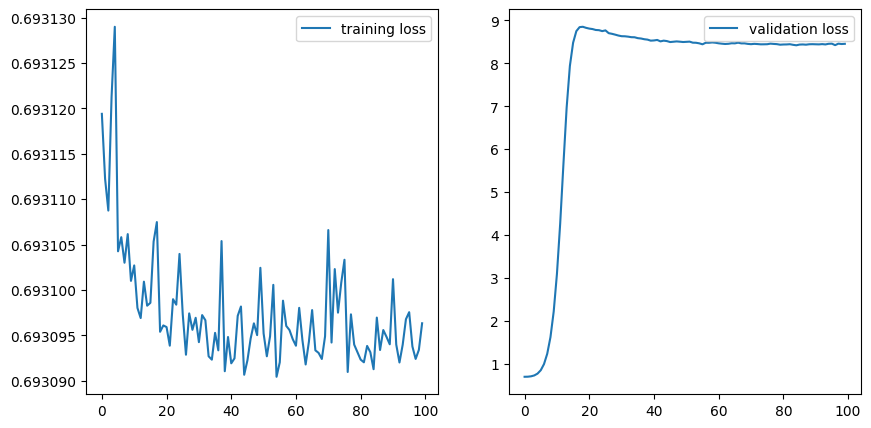

In [238]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(loss_curve,label="training loss")
ax[1].plot(loss_validation,label="validation loss")
ax[0].legend()
ax[1].legend()
plt.show()

Model doesn't seems to learn even with regularisation and class weithing (collapse to only predict one class)